## Mount Google Drive

In [1]:
from google.colab import drive

drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd "/content/drive/My Drive"
%cd "CCPD2019"
!ls

/content/drive/My Drive
/content/drive/My Drive/CCPD2019
CCPD2019.zip


In [3]:
!apt-get install unzip
!unzip CCPD2019.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Archive:  CCPD2019.zip
   creating: train/
  inflating: train/0070462164751-86_95-272&443_402&508-408&505_268&515_270&453_410&443-0_0_7_5_28_31_31-177-11.jpg  
  inflating: train/00738026819924-91_90-374&456_552&513-559&521_362&518_372&445_569&448-0_0_30_29_28_32_29-133-8.jpg  
  inflating: train/00853687739464-88_93-370&449_540&516-546&510_376&516_379&459_549&453-0_0_22_32_30_26_12-115-68.jpg  
  inflating: train/00985632183908-91_82-313&526_495&586-503&592_321&585_309&517_491&524-0_0_30_27_30_33_31-84-33.jpg  
  inflating: train/0102370689655-89_92-314&476_499&548-506&541_311&541_316&478_511&478-0_0_2_20_33_33_26-113-33.jpg  
  inflating: train/0106142241379-90_87-247&476_474&539-473&537_262&537_256&471_467&471-0_0_20_31_21_31_30-54-8.jpg  
  inflating: train/0106609195402

## Chinese City Parking Dataset

Label: 皖AT9X59


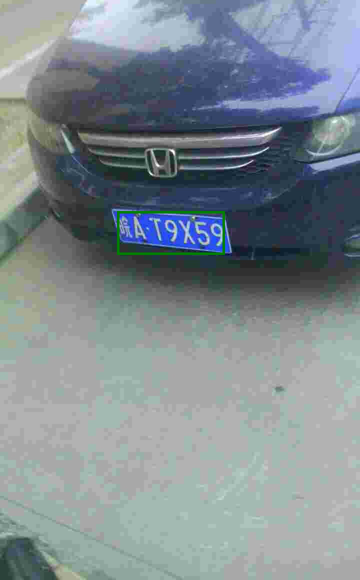

In [4]:
import os
import random
from PIL import Image, ImageDraw

# Area: Area ratio of license plate area to the entire picture area.

# Tilt degree: Horizontal tilt degree and vertical tilt degree.

# Bounding box coordinates: The coordinates of the left-up and the right-bottom vertices.

# Four vertices locations: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

# License plate number: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers.
# A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters).
# "0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows.
# The last character of each array is letter O rather than a digit 0.
# We use O as a sign of "no character" because there is no O in Chinese license plate characters.

# Brightness: The brightness of the license plate region.

# Blurriness: The Blurriness of the license plate region.

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

provNum, alphaNum, adNum = len(provinces), len(alphabets), len(ads)

img_path = "/content/drive/My Drive/CCPD2019/val"
all_files = os.listdir(img_path)

img_name = random.sample(all_files, 1)[0]
raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

# to parse license plate
lbl = raw_img_name.split("-")[-3]
lbl_list = [int(x) for x in lbl.split("_")]
prov = [provinces[lbl_list[0]]]
letter = [alphabets[lbl_list[1]]]
alphanumeric = [ads[x] for x in lbl_list[2:]]
full_lbl_str = "".join(x for x in prov + letter + alphanumeric)

# to get bbox
iname = raw_img_name.split("-")
leftUp, rightDown = [[int(eel) for eel in el.split("&")] for el in iname[2].split("_")]

# display label and image
print(f"Label: {full_lbl_str}")
pil_img = Image.open(os.path.join(img_path, img_name))
draw_img = ImageDraw.Draw(pil_img)
draw_img.rectangle(
    [(leftUp[0], leftUp[1]), (rightDown[0], rightDown[1])], outline="green", width=5
)
pil_img = pil_img.resize((int(pil_img.size[0] / 2), int(pil_img.size[1] / 2)))
pil_img.show()

## Prepare data for PPOCR Text Detection or Spotting

In [5]:
# The following is PaddleOCR Format for text detection or text spotting
# " Image file name             Image annotation information encoded by json.dumps"
# ch4_test_images/img_61.jpg    [{"transcription": "MASA", "points": [[310, 104], [416, 141], [418, 216], [312, 179]]}, {...}]

In [6]:
import os
import json
from tqdm import tqdm

alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

root_path = "/content/drive/My Drive/CCPD2019/"
img_paths = [
    "/content/drive/My Drive/CCPD2019/train",
    "/content/drive/My Drive/CCPD2019/val",
]

for img_path in img_paths:
    split = img_path.split("/")[-1]
    all_files = os.listdir(img_path)

    with open(root_path + f"{split}.txt", mode="w") as out_f:
        out_str = []
        for img_name in tqdm(all_files):
            raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

            # to parse license plate
            lbl = raw_img_name.split("-")[-3]
            lbl_list = [int(x) for x in lbl.split("_")]

            # exclude Chinese character
            letter = [alphabets[lbl_list[1]]]
            alphanumeric = [ads[x] for x in lbl_list[2:]]
            full_lbl_str = "".join(x for x in letter + alphanumeric)

            # to get bbox
            iname = raw_img_name.split("-")
            coords_1, coords_2, coords_3, coords_4 = [
                [int(eel) for eel in el.split("&")] for el in iname[3].split("_")
            ]
            current_dict = [
                {
                    "transcription": full_lbl_str,
                    "points": [coords_2, coords_3, coords_4, coords_1],
                }
            ]
            out_f.write(f"{os.path.basename(img_name)}\t{json.dumps(current_dict)}\n")

100%|██████████| 20/20 [00:00<00:00, 23301.69it/s]


## Crop Word Image for PPOCR Text Recognition

In [7]:
# The following is PaddleOCR Format for text detection or text spotting
# " Image file name           Image annotation "
# train_data/rec/train/word_001.jpg   简单可依赖
# train_data/rec/train/word_002.jpg   用科技让复杂的世界更简单

In [8]:
import os
from PIL import Image
from tqdm import tqdm

alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

root_path = "/content/drive/My Drive/CCPD2019/"
img_paths = [
    "/content/drive/My Drive/CCPD2019/train",
    "/content/drive/My Drive/CCPD2019/val",
]

for img_path in img_paths:
    split = img_path.split("/")[-1]
    all_files = os.listdir(img_path)

    crop_out_path = os.path.join(root_path, f"{split}_crop")
    if not os.path.exists(crop_out_path):
        os.makedirs(crop_out_path)

    with open(root_path + f"{split}_rec.txt", mode="w") as out_f:
        out_str = []
        for img_name in tqdm(all_files):
            raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

            # to parse license plate
            lbl = raw_img_name.split("-")[-3]
            lbl_list = [int(x) for x in lbl.split("_")]

            # exclude Chinese character
            letter = [alphabets[lbl_list[1]]]
            alphanumeric = [ads[x] for x in lbl_list[2:]]
            full_lbl_str = "".join(x for x in letter + alphanumeric)

            # to get bbox
            iname = raw_img_name.split("-")
            leftUp, rightDown = [
                [int(eel) for eel in el.split("&")] for el in iname[2].split("_")
            ]

            # crop image
            pil_img = Image.open(os.path.join(img_path, img_name))
            crop_img = pil_img.crop((leftUp[0], leftUp[1], rightDown[0], rightDown[1]))
            crop_img.save(os.path.join(crop_out_path, img_name))

            out_f.write(f"{os.path.basename(img_name)}\t{full_lbl_str}\n")

100%|██████████| 20/20 [00:00<00:00, 25.44it/s]
